# System building

## Import modules

In [2]:
import model_openface as mo ## custom helper module
import cv2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from timeit import default_timer
%matplotlib inline
%precision 2
original_path = os.getcwd()

## Construct a predefined model/weights for face recognition ([OpenFace](https://github.com/iwantooxxoox/Keras-OpenFace))

In [3]:
model = mo.model_openface()
mo.load_weight_openface(model)

## parameters

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img_row = 96
img_col = 96
box_size_factor = 10 # bigger value allows smaller bounding box
face_recog_thresh = 0.70

## helper functions
### `embed_image` to embed processed face images into 128d vectors

In [5]:
def embed_image(face_img,model):
    '''
    embed the RGB cropped face (input) into 128d vector
    use with `detect_face()`
    '''
    img = cv2.resize(face_img, (img_row,img_col)).astype('float32')
    img /= 255.0
    img = np.expand_dims(img,axis=0)
    embedding = model.predict_on_batch(img)
    return embedding

### `detect_face` to detect frontal faces in *gray* (higher accuracy than doing it in color) 

In [6]:
def detect_face(img,fc=face_cascade,flag='db',plot=False):
    '''
    Receive BGR format as an input and return coordinate(s) of detected face(s)
    
    default: flag = 'db' --> assume only one face is present in the image and return only 1 face
    flag = 'new' --> if to embed new images (possibly multiple faces)
    '''
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    height,width = img_grey.shape
    faces_raw = fc.detectMultiScale(img_grey) # higher accuracy for faces with black glasses
    faces = []
    
    # get rid of errorneous small boxes
    for face in faces_raw:
        if face[2] > (min(height,width)/box_size_factor):
            faces.append(face)
            
    if flag == 'db':
        face_box = [0,0,0,0]
        for (x,y,w,h) in faces:
            if w > face_box[2]:
                face_box = [x,y,w,h] # IGNOTE ALL OTHER FALSY FACE BOXES for database embedding
        (x,y,w,h) = face_box
        faces = [face_box]       
    if flag == 'new':
        faces = faces
        
    if plot:
        num_col = 5
        img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_color_for_crop = img_color.copy()
        for (plot_x,plot_y,plot_w,plot_h) in faces:   
            img_color = cv2.rectangle(img_color, (plot_x,plot_y), (plot_x+plot_w,plot_y+plot_h), (255,0,0), 4)

        plt.title('full image',fontdict={'fontsize':15,'fontweight':'bold'})
        plt.imshow(img_color)
        plt.axis('off')
        if len(faces) == 1:
            (plot_x,plot_y,plot_w,plot_h) = faces[0]
            fig,ax=plt.subplots(1,1,figsize=(3,3))
            cropped = img_color_for_crop[plot_y:plot_y+plot_h,plot_x:plot_x+plot_w]
            ax.imshow(cropped)
            ax.axis('off')
            fig.suptitle('Cropped face image to be embedded',fontsize=15,fontweight='bold')  
        elif len(faces)<=num_col:
            fig,axes=plt.subplots(1,len(faces),figsize=(3*len(faces),3))
            for ax,(plot_x,plot_y,plot_w,plot_h) in zip(axes.flatten(),faces):
                cropped = img_color_for_crop[plot_y:plot_y+plot_h,plot_x:plot_x+plot_w]
                ax.imshow(cropped)
                ax.axis('off')
            fig.suptitle('Cropped face image to be embedded (not ordered)',fontsize=15,fontweight='bold')
        else:
            fig, axes = plt.subplots(int(np.ceil(len(faces)/num_col)),num_col,figsize=(15,3*int(np.ceil(len(faces)/num_col))))
            fig.suptitle('Cropped face image to be embedded (not ordered)',fontsize=15,fontweight='bold')

            for ax,(plot_x,plot_y,plot_w,plot_h) in zip(axes.flatten(),faces):
                cropped = img_color_for_crop[plot_y:plot_y+plot_h,plot_x:plot_x+plot_w]
                ax.imshow(cropped)
                ax.axis('off')
            if not len(faces)==len(axes.flatten()):
                for i in axes.flatten()[len(faces)-len(axes.flatten()):]:
                    i.set_visible(False)
    return faces

### `database_face_embedding` to process and embed images in the database

In [7]:
def database_face_embedding():
    '''
    embed the images in the database
    output = {'name':embedding,...}
    '''
    database_embeddings = {}
    os.chdir(os.path.join(os.getcwd(),'image_database'))
    for img_file in os.listdir():
        name = img_file.split('.')[0]
        image_file = cv2.imread(img_file)
        faces = detect_face(image_file)
        (x, y, w, h) = faces[0]
        image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
        cropped = image_file[y:y+h,x:x+w]
        database_embeddings[name] = embed_image(cropped, model)
    os.chdir(original_path)
    return database_embeddings

### `identify_singe_face` to identify person given a single face image

In [8]:
def identify_singe_face(new_face,database_embeddings,model,verbose=None): 
    '''
    receive one new RGB face as an input
    return name_label of that face as one of the registered members or n/a
    '''    
    new_face_embedding = embed_image(new_face,model)
    name_label = ''
    min_dist = 100
    for (registered_name,registered_embedding) in database_embeddings.items():
        euc_dist = np.linalg.norm(new_face_embedding-registered_embedding)
        if verbose:
            print('Distance from {}: {:.3f}'.format(registered_name,euc_dist))
        if euc_dist < min_dist:
            min_dist = euc_dist
            name = registered_name
    if min_dist < face_recog_thresh:
        if verbose:
            print('***this is {}!***\n'.format(name.upper()))
        name_label = name
        return name_label
    else:
        if verbose:
            print('***not registered!***\n')
        name_label='n/a'
        return name_label

### `recog_face` to recognize multiple faces in a single frame (image)

In [9]:
def recog_face(img,fc=face_cascade,flag='image',verbose=None):
    '''
    receive BGR image as an input
    flag = 'image' to plot image, containing n/a info
    flag = 'video' to return image and names, without containing n/a info (used as an input for `recog_face_video`)
    ''' 
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detect_face(img,flag='new')
    names = []
    for (x, y, w, h) in faces:
        cropped = img_color[y:y+h,x:x+w]
        if verbose:
            name = identify_singe_face(cropped,database_embeddings,model,verbose=True)
        if not verbose:
            name = identify_singe_face(cropped,database_embeddings,model)
        
        text = '{}'.format(name)
        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN,2,5)[0]
        text_offset_x = x-3
        text_offset_y = y
        box_coords = ((text_offset_x, text_offset_y+10), (text_offset_x+text_width,text_offset_y-text_height-10))
        
        if name != 'n/a':
            img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (255,0,0), 4)
            img_color = cv2.rectangle(img_color, box_coords[0], box_coords[1], (255,0,0), cv2.FILLED)
            img_color = cv2.putText(img_color,text,(x,y),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),3)
            names.append(name)
            
        if flag == 'image':     
            if name == 'n/a':
                img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (0,0,255), 4)
                img_color = cv2.rectangle(img_color, box_coords[0], box_coords[1], (0,0,255), cv2.FILLED)    
                img_color = cv2.putText(img_color,text,(x,y),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),3)

    if flag == 'image':      
        plt.figure(figsize=(8,8))
        plt.imshow(img_color)
        plt.axis('off')   
    if flag == 'video':
        return img_color,names

### `recog_face_video` to recognize multiple faces in a video

In [10]:
def recog_face_video(cap,save=False,savename=None,output_dimension=(720,1280)):
    '''
    receive cv2.VideoCapture() as an input
    if save = TRUE, savename and output_dimension need to be set as well.
    '''
    if (cap.isOpened() == False):
        print('cannot read a video')
    (output_width,output_height) = output_dimension

    if save:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter('Readme_images/'+savename+'.avi',fourcc,30,(output_width,output_height)) ## smaller dimension for efficient .gif conversion
    total_frame_detected = {name: 0 for name in registered_name}

    total_second_per_frame = 0
    while cap.isOpened():
        stime = default_timer()
        ret,frame = cap.read()

        if ret == True:
            frame = cv2.resize(frame,(output_width,output_height),fx=0,fy=0,interpolation=cv2.INTER_AREA)
#             frame = cv2.rotate(frame,3)
    #         frame = cv2.flip(frame,-1)

            new_frame,names = recog_face(frame,flag='video')
        
            second_per_frame = default_timer()-stime
            total_second_per_frame += second_per_frame
            
            fps = 1/second_per_frame
            
            for name in names:
                total_frame_detected[name] += 1 ## count the number of frames detected
            
            new_frame = cv2.putText(new_frame,'fps: '+format(fps, '.2f'),(0,30),cv2.FONT_HERSHEY_PLAIN,2,(0,0,0),3)
            new_frame = cv2.cvtColor(new_frame, cv2.COLOR_RGB2BGR)
            cv2.imshow('frame',new_frame)
            if save:
                out.write(new_frame)
            if cv2.waitKey(1) & 0xff == ord('q'): #int(1/video_fps*1000) for waitkey
                break
        else:
            break
    cv2.destroyAllWindows()
    cap.release()
    if save:
        out.release()
    print('total time for on-stream video processing: {:.2f} s'.format(total_second_per_frame))
    return total_frame_detected

### `get_correct_duration` to normalize the detection duration based on the original video FPS

In [11]:
def get_correct_duration(input_video,total_frame_detected):
    input_fps = input_video.get(cv2.CAP_PROP_FPS)
    input_second_per_frame = 1/input_fps
    input_video.release()
    duration = {}
    for name,num_frame in total_frame_detected.items():
        if num_frame > 0:
            total_frame_detected[name]=num_frame*input_second_per_frame
            duration[name] = total_frame_detected[name]
    return duration

# Testing on images and videos!

## Image testing files

In [12]:
db_img_sean = cv2.imread(os.path.join('image_database','SEAN.jpeg'))
db_img_kevin = cv2.imread(os.path.join('image_database','KEVIN.jpg'))
db_img_james = cv2.imread(os.path.join('image_database','JAMES.jpeg'))

test_img_multi_1 = cv2.imread(os.path.join('test','multi_1.jpeg'))

## `detect_face` examples

[[175, 255, 192, 192]]

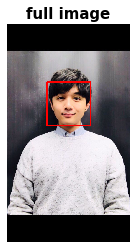

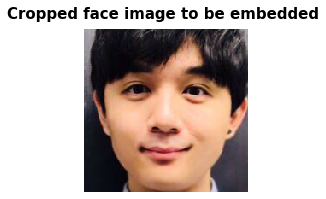

In [13]:
detect_face(db_img_sean,fc=face_cascade,flag='db',plot=True)

[array([237, 392, 167, 167], dtype=int32),
 array([507, 490, 129, 129], dtype=int32),
 array([754, 435, 141, 141], dtype=int32)]

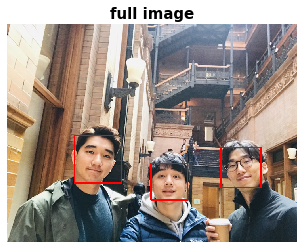

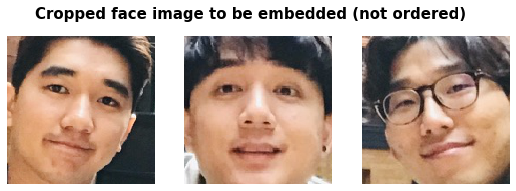

In [14]:
detect_face(test_img_multi_1,fc=face_cascade,flag='new',plot=True)

NOTE: In order to make sure that the face is correctly detected for database registration:
* the input image needs to contain only a single frontal-looking face
* use `flag='db'` in `detect_face()`

## Database embedding

In [15]:
database_embeddings = database_face_embedding()
registered_name = list(database_embeddings.keys())
print('Current database contains {} images: \n{}'.format(len(database_embeddings),[key.upper() for key in registered_name]))

Current database contains 3 images: 
['KEVIN', 'JAMES', 'SEAN']


## Face detection examples with images

For validation, used the identical picture stored in the database --> 0 distance from *KEVIN* **(model confirmed!)**

For the details of the wrongly-detected blue bounding box, please refer to the description below in this subsection. In short, this problem arose because `recog_face` uses `detect_face(flag='new')`. However, this would not deteriorate the purpose of this application since we are only interested in the red bounding boxes that are recognized as one of the registered members.

Distance from KEVIN: 0.000
Distance from JAMES: 0.967
Distance from SEAN: 0.756
***this is KEVIN!***

Distance from KEVIN: 1.101
Distance from JAMES: 1.123
Distance from SEAN: 1.196
***not registered!***

CPU times: user 160 ms, sys: 24.6 ms, total: 185 ms
Wall time: 55.1 ms


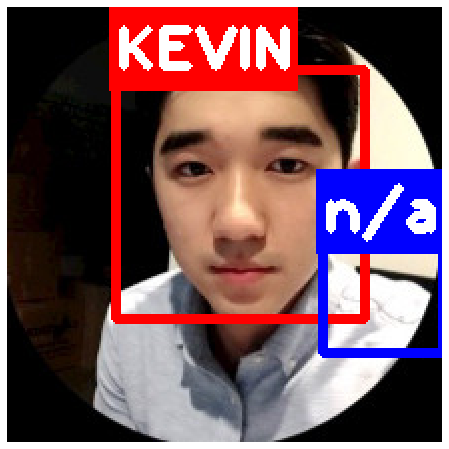

In [16]:
%%time
recog_face(db_img_kevin,verbose=True)

Distance from KEVIN: 0.459
Distance from JAMES: 0.783
Distance from SEAN: 0.800
***this is KEVIN!***

Distance from KEVIN: 1.044
Distance from JAMES: 1.012
Distance from SEAN: 1.094
***not registered!***

Distance from KEVIN: 0.676
Distance from JAMES: 0.984
Distance from SEAN: 0.610
***this is SEAN!***

CPU times: user 1.04 s, sys: 41.9 ms, total: 1.09 s
Wall time: 194 ms


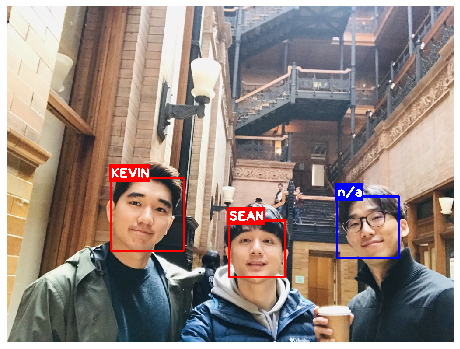

In [17]:
%%time
recog_face(test_img_multi_1,verbose=True)

A smaller `box_size_factor` value may filter small bounding boxes that are wrongly detected in some images. Or, as we know that those erroneous bounding boxes are recognized as 'n/a' by the face recognizer, the blue bounding boxes (a face of an unregistered person and any false faces) can be removed entirely as they do not convey any meaningful information in the application. 

## Video testing files

In [18]:
test_video_sean= cv2.VideoCapture(os.path.join('test','sean_test.mov'))

In [19]:
# saving file name
save_file_name = 'TTT_v3_sean_test'

## Face detection examples with videos

The processing FPS can be improved by lowering the `output_dimension` parameter in `recog_face_video` ***(default is HD: 1280 X 720 or 720p)***. Nonetheless, the original playing FPS (~ 30) was retrieved in the saved output video.  

In [20]:
total_frame_detected = recog_face_video(test_video_sean,save=True,savename=save_file_name)

total time for on-stream video processing: 33.74 s


Based on the FPS of the original video, the total number of frames detected are converted to the duration

In [21]:
test_video_sean= cv2.VideoCapture(os.path.join('test','sean_test.mov'))
get_correct_duration(test_video_sean,total_frame_detected)

{'KEVIN': 1.20, 'SEAN': 6.70}

In this particular video, only I was present at all times. Assuming the arbitrary face detection algorithm was working properly, my face was detectable for 7.9 seconds, but recognized for 6.7 seconds. This turns into ***~ 85%*** accuracy for the given database imagesets. 

***
## Appendix
### input video info

In [23]:
video = cv2.VideoCapture(os.path.join('test','sean_test.mov'))

fps = video.get(cv2.CAP_PROP_FPS)
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print('# of frames: {}'.format(length))
print('FPS: {:.2f}'.format(fps))
video.release(); 
print('duration: {:.2f}'.format(length/fps))

# of frames: 417
FPS: 30.00
duration: 13.90


### new video info

In [24]:
video = cv2.VideoCapture(os.path.join('Readme_images',save_file_name+'.avi'))

fps = video.get(cv2.CAP_PROP_FPS)
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print('# of frames: {}'.format(length))
print('FPS: {:.2f}'.format(fps))
video.release(); 
print('duration: {:.2f}'.format(length/fps))

# of frames: 417
FPS: 30.00
duration: 13.90
